### Evaluation notebook for trained and saved models

In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=''
import numpy as np
import torch
from torch import nn
from mapsgan import SGANSolver, data_loader, BicycleSolver, BicycleGenerator
from sgan import TrajectoryGenerator, TrajectoryDiscriminator
import mapsgan.experiments as experiments
from mapsgan.evaluation import Visualization
from pathlib import Path
import os, glob
import matplotlib.pyplot as plt

env: CUDA_VISIBLE_DEVICES=''


In [5]:
l = [1,2,3]
sum(l)
l.append(3)
sum(l)

9

In [ ]:
torch.cuda.is_available()

### Set these manually according to the script

In [3]:
mode = 'cvae'
fileprefix = '/cloud/sgan_bicy_1'
lr_gen = 1e-3
lr_dis = 1e-3
loss_weights={'disc': 1, 'traj': 2, 'kl': 0.1, 'z': 0.5}
obs_len=8,
pred_len=12
embedding_dim=16
encoder_h_dim=32
decoder_h_dim=32
mlp_dim=64
num_layers=1
noise_dim=(8,)
noise_type='gaussian'
noise_mix_type='global'
pooling_type='pool_net'

In [25]:
root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
filesearch = root_path + '/models' + fileprefix + '*10000*' # can change here acc to saved epoch
filelist = glob.glob(filesearch)
filename = filelist[0]

In [26]:
filename

'/home/yy/ADL4CV/mapsgan/models/cloud/sgan_bicy_1_20190123-225524_epoch_10000'

### Initializing dataloader, models, solver

In [67]:
experiment = experiments.ETH() # we store filepaths and arguments in here
dataset, trainloader = data_loader(in_len=8, out_len=12, batch_size=64, num_workers=1, path=experiment.train_dir,
                                  shuffle=True)
_ , testloader = data_loader(in_len=8, out_len=12, batch_size=1, num_workers=1, path=experiment.test_dir,
                                  shuffle=False)

In [27]:
generator_sgan = TrajectoryGenerator(obs_len=8,
                                pred_len=12,
                                embedding_dim=16,
                                encoder_h_dim=32,
                                decoder_h_dim=32,
                                mlp_dim=64,
                                num_layers=1,
                                noise_dim=(8,),
                                noise_type='gaussian',
                                noise_mix_type='global',
                                pooling_type='pool_net',
                                pool_every_timestep=1,
                                dropout=0,
                                bottleneck_dim=32,
                                neighborhood_size=2,
                                grid_size=8,
                                batch_norm=0)
generator = BicycleGenerator(generator=generator_sgan, start_mode=mode,
                    embedding_dim=embedding_dim, h_dim=decoder_h_dim-8, z_dim=8,
                    in_len=obs_len, out_len=pred_len, noise_type=noise_type, noise_mix_type=noise_mix_type )
discriminator = TrajectoryDiscriminator(obs_len=8,
                                        pred_len=12,
                                        embedding_dim=16,
                                        h_dim=64,
                                        mlp_dim=64,
                                        num_layers=1,
                                        dropout=0,
                                        batch_norm=0,
                                        d_type='local')

In [28]:
solver = BicycleSolver(generator, discriminator,
                    loss_weights=loss_weights,
                    optims_args={'generator': {'lr': lr_gen}, 'discriminator': {'lr': lr_dis}})

### Looking at losses

In [29]:
epochs = solver.load_checkpoint(filename)

In [1]:
vis = Visualization()
vis.loss(solver.train_loss_history['clr'])

NameError: name 'Visualization' is not defined

### Looking at predictions

In [33]:
output = solver.test(testloader, load_checkpoint_from=filename) #can also use trainloader for overfit

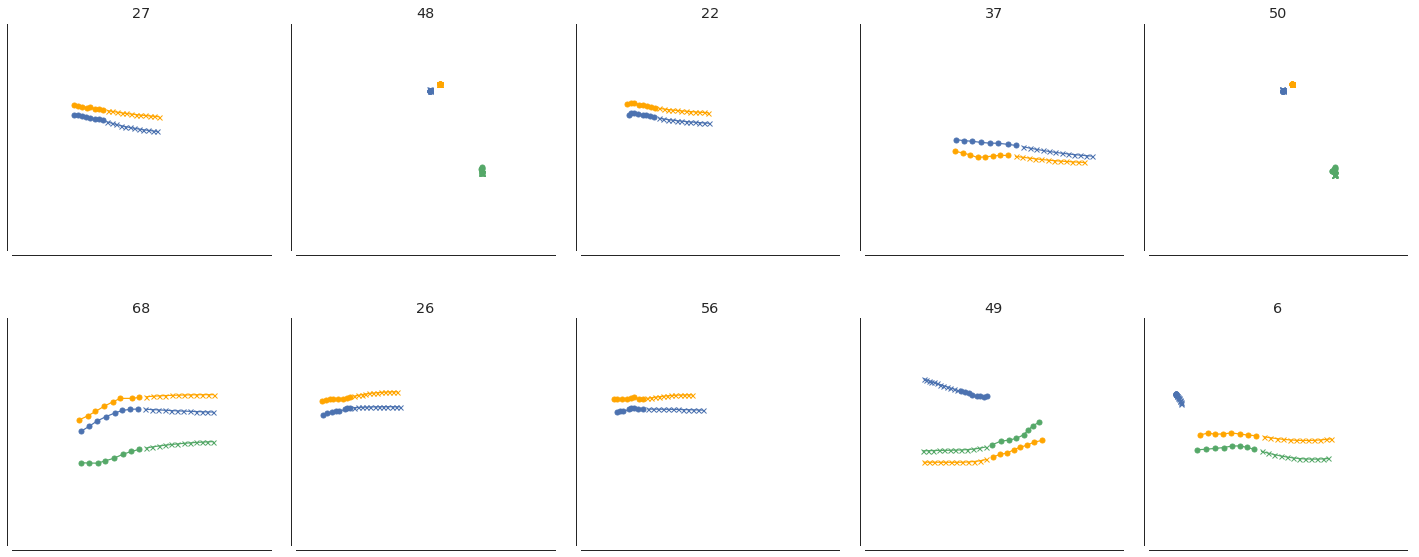

In [36]:
vis = Visualization()
ll = vis.trajectories(output, scenes=10)

#### Looking at latent space interpolation

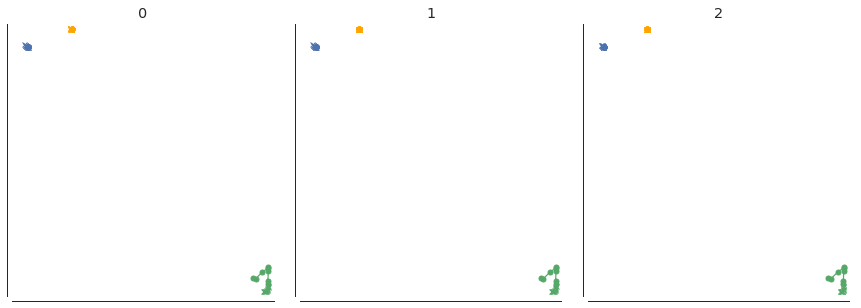

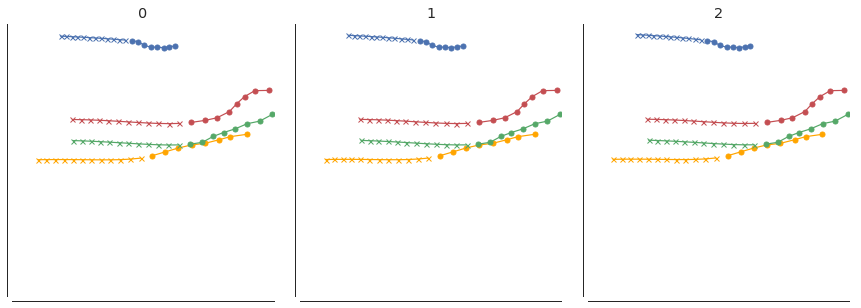

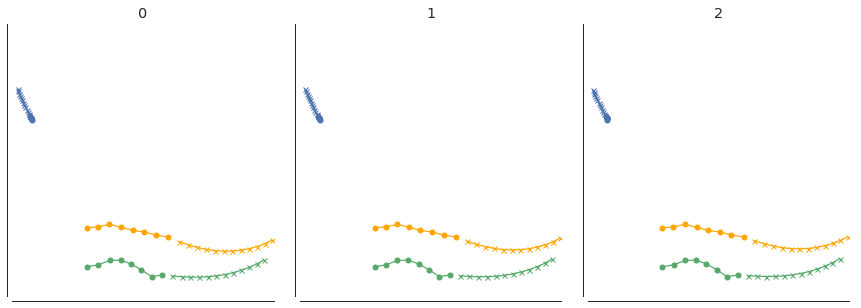

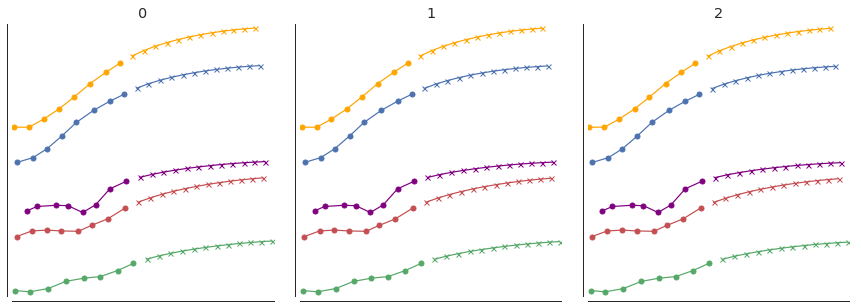

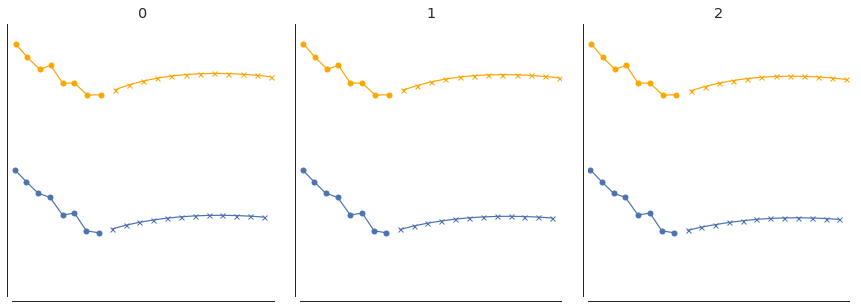

In [70]:
for s in [3,25,30,44,65]:
    out = solver.interpolate(testloader, scene=s, seed=10, stepsize=0.5)
    vis.trajectories(out, scenes = None)
    plt.show()